In [1]:
# based on this tutorial
# https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection

In [2]:
from apex import amp
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from os.path import join
from os import listdir
from xml.etree import ElementTree
import re

from tqdm import tqdm

torch.cuda.set_device('cuda:1')

from model import SSD300, MultiBoxLoss

In [3]:
data_path = '/home/egor/job/CAPTCHA_recognition/data/labels+boxes/'

# Data preperation

In [4]:
from utils import resize

def random_crop(image, boxes, labels):
    """
    Performs a random crop in the manner stated in the paper. Helps to learn to detect larger and partial objects.
    Note that some objects may be cut out entirely.
    Adapted from https://github.com/amdegroot/ssd.pytorch/blob/master/utils/augmentations.py
    :param image: image, a tensor of dimensions (3, original_h, original_w)
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :param difficulties: difficulties of detection of these objects, a tensor of dimensions (n_objects)
    :return: cropped image, updated bounding box coordinates, updated labels, updated difficulties
    """
    original_h = image.size(1)
    original_w = image.size(2)
    # Keep choosing a minimum overlap until a successful crop is made
    while True:
        max_trials = 50
        for _ in range(max_trials):
            # Crop dimensions must be in [0.3, 1] of original dimensions
            # Note - it's [0.1, 1] in the paper, but actually [0.3, 1] in the authors' repo
            min_scale = 0.3
            scale_h = np.random.uniform(0.7, 1)
            scale_w = np.random.uniform(0.7, 1)
            new_h = int(scale_h * original_h)
            new_w = int(scale_w * original_w)

            # Crop coordinates (origin at top-left of image)
            left = np.random.randint(0, original_w - new_w)
            right = left + new_w
            top = np.random.randint(0, original_h - new_h)
            bottom = top + new_h
            crop = torch.FloatTensor([left, top, right, bottom])  # (4)

            # Crop image
            new_image = image[:, top:bottom, left:right]  # (3, new_h, new_w)

            # Find centers of original bounding boxes
            bb_centers = (boxes[:, :2] + boxes[:, 2:]) / 2.  # (n_objects, 2)

            # Find bounding boxes whose centers are in the crop
            centers_in_crop = (bb_centers[:, 0] > left) * (bb_centers[:, 0] < right) * (bb_centers[:, 1] > top) * (
                    bb_centers[:, 1] < bottom)  # (n_objects), a Torch uInt8/Byte tensor, can be used as a boolean index
        
            # If not a single bounding box has its center in the crop, try again
            if not centers_in_crop.any():
                continue
            
            # Discard bounding boxes that don't meet this criterion
            new_boxes = boxes[centers_in_crop, :]
            new_labels = labels[centers_in_crop]

            # Calculate bounding boxes' new coordinates in the crop
            new_boxes[:, :2] = torch.max(new_boxes[:, :2], crop[:2])  # crop[:2] is [left, top]
            new_boxes[:, :2] -= crop[:2]
            new_boxes[:, 2:] = torch.min(new_boxes[:, 2:], crop[2:])  # crop[2:] is [right, bottom]
            new_boxes[:, 2:] -= crop[:2]

            return new_image, new_boxes, new_labels


def transform(image, boxes, labels, split):
    assert split in {'TRAIN', 'TEST'}
    new_image = image
    new_boxes = boxes
    new_labels = labels
    # Skip the following operations if validation/evaluation
    if split == 'TRAIN':
        
        # Convert PIL image to Torch tensor
        new_image = F.to_tensor(new_image)

        # Randomly crop image (zoom in)
        if np.random.randint(100) > 15:
            new_image, new_boxes, new_labels = random_crop(new_image, new_boxes, new_labels)
        
        # Convert Torch tensor to PIL image
        new_image = F.to_pil_image(new_image)
        
    # Resize image to (300, 300) - this also converts absolute boundary coordinates to their fractional form
    new_image, new_boxes = resize(new_image, new_boxes, dims=(300, 300))

    # Convert PIL image to Torch tensor
    new_image = F.to_tensor(new_image)

    return new_image, new_boxes, new_labels

In [5]:
class CAPTCHA_dataset(Dataset):
    
    def __init__(self, path, img_transforms=[T.ToTensor()], vocab=None, split='TEST'):
        self.split = split
        self.transform = T.Compose(img_transforms)
        self._img_names = sorted([name for name in listdir(join(path)) if '.jpg' in name])
        self._xml_names = sorted([name for name in listdir(join(path)) if '.xml' in name])
        
        # check if image names correspond to xml names
        for img_name, xml_name in zip(self._img_names, self._xml_names):
            if not img_name[:-4] == xml_name[:-4]:
                raise ValueError(f'img {img_name} does not correspont to xml {xml_name}')
        
        self.images = []
        for img_name in self._img_names:
            self.images.append(Image.open(join(path, img_name)).convert('RGB'))
       
        self.boxes = []
        self.labels = []
        for i, xml_name in enumerate(self._xml_names):
            cur_labels, cur_boxes = [], []
            xml = ElementTree.parse(join(path, xml_name)).getroot()
            w, h = self.images[i].size # pillow image
            for obj in xml.iter('object'):
                bndbox = obj.find('bndbox')
                x0, y0 = int(bndbox.find('xmin').text), int(bndbox.find('ymin').text)
                x1, y1 = int(bndbox.find('xmax').text), int(bndbox.find('ymax').text)
#                 x0, y0, x1, y1 = x0 / w, y0 / h, x1 / w, y1 / h
                cur_boxes.append((x0, y0, x1, y1))
                cur_labels.append(obj.find('name').text)
            self.boxes.append(cur_boxes)
            self.labels.append(cur_labels)
            
        if vocab:
            self.vocab = vocab
        else:
            self.vocab = list(set([char for chars in self.labels for char in chars]))
            
        self.lbl2indx = {lbl: indx for indx, lbl in enumerate(self.vocab)}
        self.indx2lbl = {indx: lbl for lbl, indx in self.lbl2indx.items()}
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, indx):
#         img = self.transform(self.images[indx])
        img = self.images[indx]
        labels = torch.LongTensor([self.lbl2indx[char] for char in self.labels[indx]])
        boxes = torch.tensor(self.boxes[indx], dtype=torch.float32)
        
        img, boxes, labels = transform(img, boxes, labels, self.split)
        
        return img, boxes, labels
    
    
def custom_collate(batch):

    images = list()
    boxes = list()
    labels = list()

    for b in batch:
        images.append(b[0])
        boxes.append(b[1])
        labels.append(b[2])

    images = torch.stack(images, dim=0)

    return images, boxes, labels

Checking that datasets work

In [6]:
# vocab = ['1','2','3','4','5','6','7','8','9','0','A','B','C','D','E','F','G','H','I','J','K', \
#          'L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# train_dataset = CAPTCHA_dataset(join(data_path, 'train'), vocab=vocab, split='TRAIN')
# # val_dataset = CAPTCHA_dataset(join(data_path, 'val'), vocab=vocab)
# # test_dataset = CAPTCHA_dataset(join(data_path, 'test'), vocab=vocab)

In [7]:
# for _ in range(5):
#     train_dataset = CAPTCHA_dataset(join(data_path, 'train'), vocab=vocab, split='TRAIN')
#     img, boxes, labels = train_dataset[0]
# #     img, boxes, labels = transform(img, boxes, labels, 'TRAIN')
#     fig, ax = plt.subplots(1)
#     ax.imshow(img.permute(1,2,0).detach().cpu().numpy())
#     for box in boxes.detach().cpu().numpy():
#         img_h, img_w, _ = img.permute(1,2,0).detach().cpu().numpy().shape
#         x0, y0, x1, y1 = box
#         x0, y0, x1, y1 = x0 * img_w, y0 * img_h, x1 * img_w, y1 * img_h
#         h, w = y1 - y0, x1 - x0
#         rect = patches.Rectangle((x0,y0),w,h,linewidth=1,edgecolor='w',facecolor='none')
#         ax.add_patch(rect)
#     plt.show()

# Training

In [8]:
def train(model, loader, criterion, optimizer, epoch=None, lr_scheduler=None, fp16=False):
    model.train()
    
    if epoch: tqdm_text = f'Training {epoch} epoch'
    else:  tqdm_text = f'Training'
        
    epoch_loss = 0.
    for imgs, boxes, labels in tqdm(loader, desc=tqdm_text):
        imgs = imgs.cuda()
        boxes = [i.cuda() for i in boxes]
        labels = [i.cuda() for i in labels]
        
        pred_boxes, pred_scores = model(imgs)
        
        loss = criterion(pred_boxes, pred_scores, boxes, labels)
        
        optimizer.zero_grad()
        if fp16:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        optimizer.step()
        
        if lr_scheduler:
            lr_scheduler.step()
            
        epoch_loss += loss.item()
        
    return epoch_loss / len(loader)


def evaluate(model, loader, criterion, epoch=None):
    model.eval()
    
    if epoch: tqdm_text = f'Evaluating {epoch} epoch'
    else:  tqdm_text = f'Evaluating'
    
    epoch_loss = 0.
    with torch.no_grad():
        for imgs, boxes, labels in tqdm(loader, desc=tqdm_text):
            imgs = imgs.cuda()
            boxes = [i.cuda() for i in boxes]
            labels = [i.cuda() for i in labels]

            pred_boxes, pred_scores = model(imgs)

            loss = criterion(pred_boxes, pred_scores, boxes, labels)

            epoch_loss += loss.item()
        
    return epoch_loss / len(loader)


class History():
    
    def __init__(self):
        
        self.train_losses = []
        self.val_losses = []
        
    def update(self, train_loss, val_loss):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        

In [11]:
def patrially_load_state_dict(model, state_dict):
    """
    copies params which can be loaded from given sate dict in place
    returns: dict {layer_name: whether it was changed}
    """
    were_loaded = {}
    own_state = model.state_dict()
    for name, param in state_dict.items():
        param = param.data
        if name not in own_state:
            were_loaded[name] = False
            continue
        if own_state[name].shape != param.shape:
            were_loaded[name] = False
            continue
        own_state[name].copy_(param)
        were_loaded[name] = True
    return were_loaded

In [12]:
config = dict(
    epochs = 70,
    bs = 16,
    wait = 5,
)

vocab = ['1','2','3','4','5','6','7','8','9','0','A','B','C','D','E','F','G','H','I','J','K', \
         'L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

transforms = [T.Resize((300,300)), T.ToTensor()]
train_dataset = CAPTCHA_dataset(join(data_path, 'train'), img_transforms=transforms, vocab=vocab, split='TRAIN')
val_dataset = CAPTCHA_dataset(join(data_path, 'val'), img_transforms=transforms, vocab=vocab)
test_dataset = CAPTCHA_dataset(join(data_path, 'test'), img_transforms=transforms, vocab=vocab)

train_loader = DataLoader(train_dataset, config['bs'], collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, config['bs'], collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, config['bs'], collate_fn=custom_collate)

history = History()

In [13]:
ssd_model = SSD300(len(vocab))
ssd_model.cuda()

checkpointed_state_dict = torch.load('models/BEST_checkpoint_ssd300.pth')['model'].state_dict()

was_loaded_dict = patrially_load_state_dict(ssd_model, checkpointed_state_dict)


Loaded base model.



/home/egor/venvs/astral_base/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'model.SSD300' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/egor/venvs/astral_base/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'model.VGGBase' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/egor/venvs/astral_base/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribu

In [14]:
param_groups = [
    {'params': [w for name, w in ssd_model.base.named_parameters() if re.findall('[a-z]1', name)]},
    {'params': [w for name, w in ssd_model.base.named_parameters() if re.findall('[a-z]2', name)]},
    {'params': [w for name, w in ssd_model.base.named_parameters() if re.findall('[a-z]3', name)]},
    {'params': [w for name, w in ssd_model.base.named_parameters() if re.findall('[a-z]4', name)]},
    {'params': [w for name, w in ssd_model.base.named_parameters() if re.findall('[a-z]5', name)]},
    {'params': [w for name, w in ssd_model.base.named_parameters() if re.findall('[a-z][67]', name)]},
    {'params': ssd_model.aux_convs.parameters()},
    {'params': ssd_model.pred_convs.parameters()}
]

optimizer = torch.optim.Adam(param_groups, lr=1e-3)
# optimizer = torch.optim.AdamW(param_groups, lr=1e-3)
criterion = MultiBoxLoss(ssd_model.priors_cxcy)

/home/egor/venvs/astral_base/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [15]:
ssd_model, optimizer = amp.initialize(ssd_model, optimizer, opt_level="O1", verbosity=0)

In [16]:
for name, param in ssd_model.named_parameters():
    if was_loaded_dict[name] is True:
        param.requires_grad = False
    else:
        param.requires_grad = True

In [17]:
best_loss = np.inf
for epoch in range(2):
    
    train_loss = train(ssd_model, train_loader, criterion, optimizer, epoch=epoch+1, fp16=True)
    val_loss = evaluate(ssd_model, val_loader, criterion, epoch=epoch+1)
    
    print('{}: train loss {:.4f}, val loss {:.4f}'.format(epoch+1, train_loss, val_loss))

Training 2 epoch:   4%|▍         | 1/26 [00:00<00:04,  5.10it/s]

1: train loss 11.5752, val loss 7.2989


Evaluating 2 epoch: 100%|██████████| 5/5 [00:00<00:00,  6.61it/s]

2: train loss 6.7512, val loss 6.8044


In [18]:
for param in ssd_model.parameters():
    param.requires_grad = True

In [19]:
base_lr = 1e-3

def lr_update(n, base_lr):
    # epochs are counted from 0
    return base_lr * 0.7 ** n

for i, group in enumerate(optimizer.param_groups[::-1]):
    cur_lr = lr_update(i, base_lr)
    group['lr'] = cur_lr

In [20]:
for group in optimizer.param_groups:
    print(group['lr'])

8.235429999999997e-05
0.00011764899999999997
0.00016806999999999995
0.00024009999999999995
0.00034299999999999993
0.00049
0.0007
0.001


In [22]:
best_loss = np.inf
no_improvement = 0
for epoch in range(config['epochs']):
    
    train_loss = train(ssd_model, train_loader, criterion, optimizer, epoch=epoch+1, fp16=True)
    val_loss = evaluate(ssd_model, val_loader, criterion, epoch=epoch+1)
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save({
            'model_state_dict': ssd_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, 'models/best_ssd_simple_adam.ptr')
        no_improvement = 0
    
    no_improvement += 1
    if no_improvement > config['wait']:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr'] * 0.7
        no_improvement = 0
        print('Learning rates were decreased')
    history.update(train_loss, val_loss)
    
    print('{}: train loss {:.4f}, val loss {:.4f}'.format(epoch+1, train_loss, val_loss))

Training 2 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

1: train loss 6.7387, val loss 6.3120


Training 3 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

2: train loss 5.8732, val loss 5.5519


Training 4 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

3: train loss 5.2536, val loss 5.8466


Training 5 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

4: train loss 4.8446, val loss 5.6286


Training 6 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

5: train loss 4.7876, val loss 5.3892


Training 7 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

6: train loss 4.1793, val loss 4.4242


Training 8 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

7: train loss 3.9456, val loss 4.2541


Training 9 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

8: train loss 3.6048, val loss 3.8340


Training 10 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

9: train loss 3.3235, val loss 4.7157


Training 11 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

10: train loss 3.3326, val loss 4.3396


Training 12 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

11: train loss 3.1298, val loss 3.6058


Training 13 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

12: train loss 2.9956, val loss 3.7592


Training 14 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

13: train loss 2.9551, val loss 3.5774


Training 15 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

14: train loss 2.7015, val loss 2.9990


Training 16 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

15: train loss 2.6373, val loss 3.3434


Training 17 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

16: train loss 2.9227, val loss 3.3587


Training 18 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

17: train loss 2.9150, val loss 2.9713


Training 19 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

18: train loss 2.4332, val loss 2.8254


Training 20 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

19: train loss 2.4383, val loss 3.0104


Training 21 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

20: train loss 2.3839, val loss 2.5176


Training 22 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

21: train loss 2.1594, val loss 2.6269


Training 23 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

22: train loss 2.0534, val loss 2.9226


Training 24 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

23: train loss 2.0536, val loss 2.4712


Training 25 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

24: train loss 1.9117, val loss 2.7005


Training 26 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

25: train loss 1.8385, val loss 2.4553


Training 27 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

26: train loss 1.8144, val loss 2.6431


Training 28 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

27: train loss 1.8880, val loss 2.3944


Training 29 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

28: train loss 1.6983, val loss 2.7149


Training 30 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

29: train loss 1.7270, val loss 2.4186


Training 31 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

30: train loss 1.7004, val loss 2.3909


Training 32 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

31: train loss 1.6401, val loss 2.5684


Training 33 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

32: train loss 1.5674, val loss 2.4921


Training 34 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

33: train loss 1.5936, val loss 2.4742


Training 35 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

34: train loss 1.6282, val loss 2.5571


Training 36 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

Learning rates were decreased
35: train loss 1.6308, val loss 3.0673


Training 37 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

36: train loss 1.6824, val loss 2.1090


Training 38 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

37: train loss 1.4440, val loss 2.0945


Training 39 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

38: train loss 1.3781, val loss 2.1227


Training 40 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

39: train loss 1.3217, val loss 2.0948


Training 41 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

40: train loss 1.3070, val loss 2.0759


Training 42 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

41: train loss 1.3676, val loss 2.0423


Training 43 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

42: train loss 1.3027, val loss 2.1238


Training 44 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

43: train loss 1.3063, val loss 2.2151


Training 45 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

44: train loss 1.3079, val loss 2.0719


Training 46 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

45: train loss 1.1887, val loss 2.0886


Training 47 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

Learning rates were decreased
46: train loss 1.2004, val loss 2.1405


Training 48 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

47: train loss 1.2135, val loss 1.9238


Training 49 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

48: train loss 1.1465, val loss 2.1765


Training 50 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

49: train loss 1.1025, val loss 1.9565


Training 51 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

50: train loss 1.0935, val loss 1.9522


Training 52 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

51: train loss 1.0345, val loss 2.0641


Training 53 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

Learning rates were decreased
52: train loss 1.1089, val loss 2.1687


Training 54 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

53: train loss 1.1016, val loss 1.9303


Training 55 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

54: train loss 0.9544, val loss 2.0152


Training 56 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

55: train loss 0.9320, val loss 2.0233


Training 57 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

56: train loss 0.9687, val loss 1.9771


Training 58 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

57: train loss 0.9683, val loss 1.8955


Training 59 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

58: train loss 0.9546, val loss 1.9843


Training 60 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

59: train loss 0.9190, val loss 1.9249


Training 61 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

60: train loss 0.9488, val loss 2.1035


Training 62 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

61: train loss 0.9444, val loss 2.1354


Training 63 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

Learning rates were decreased
62: train loss 0.9443, val loss 1.9874


Training 64 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

63: train loss 0.9299, val loss 1.9668


Training 65 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

64: train loss 0.9388, val loss 1.8715


Training 66 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

65: train loss 0.9039, val loss 1.8916


Training 67 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

66: train loss 0.8464, val loss 1.9289


Training 68 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

67: train loss 0.8962, val loss 1.9151


Training 69 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

68: train loss 0.8885, val loss 1.9059


Training 70 epoch:   0%|          | 0/26 [00:00<?, ?it/s]

Learning rates were decreased
69: train loss 0.8356, val loss 1.8980


Evaluating 70 epoch: 100%|██████████| 5/5 [00:00<00:00,  6.59it/s]

70: train loss 0.8686, val loss 1.9104


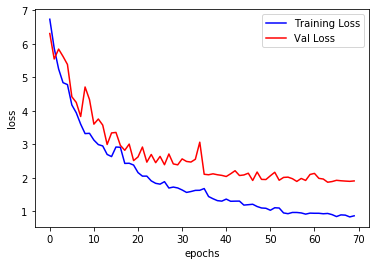

In [31]:
epochs = list(range(len(history.train_losses)))
plt.plot(epochs, history.train_losses, 'b')
plt.plot(epochs, history.val_losses, 'r')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Training Loss', 'Val Loss'])
plt.show();

In [32]:
ssd_model.load_state_dict(torch.load('models/best_ssd_simple_adam.ptr')['model_state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [33]:
from utils import *
from PIL import Image, ImageDraw, ImageFont

resize = T.Resize((300, 300))
to_tensor = T.ToTensor()

def detect(model, original_image, indx2lbl, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.

    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """
    model.eval()

    image = to_tensor(resize(original_image)).cuda()

    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)
    
    det_boxes = det_boxes[0].detach().cpu().numpy()

    # Transform to original image dimensions
    original_dims = np.array([original_image.width, original_image.height, original_image.width, original_image.height])
    det_boxes = det_boxes * original_dims

    det_labels = [indx2lbl[l] for l in det_labels[0].detach().cpu().tolist()]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image

    return original_image, det_boxes, det_labels

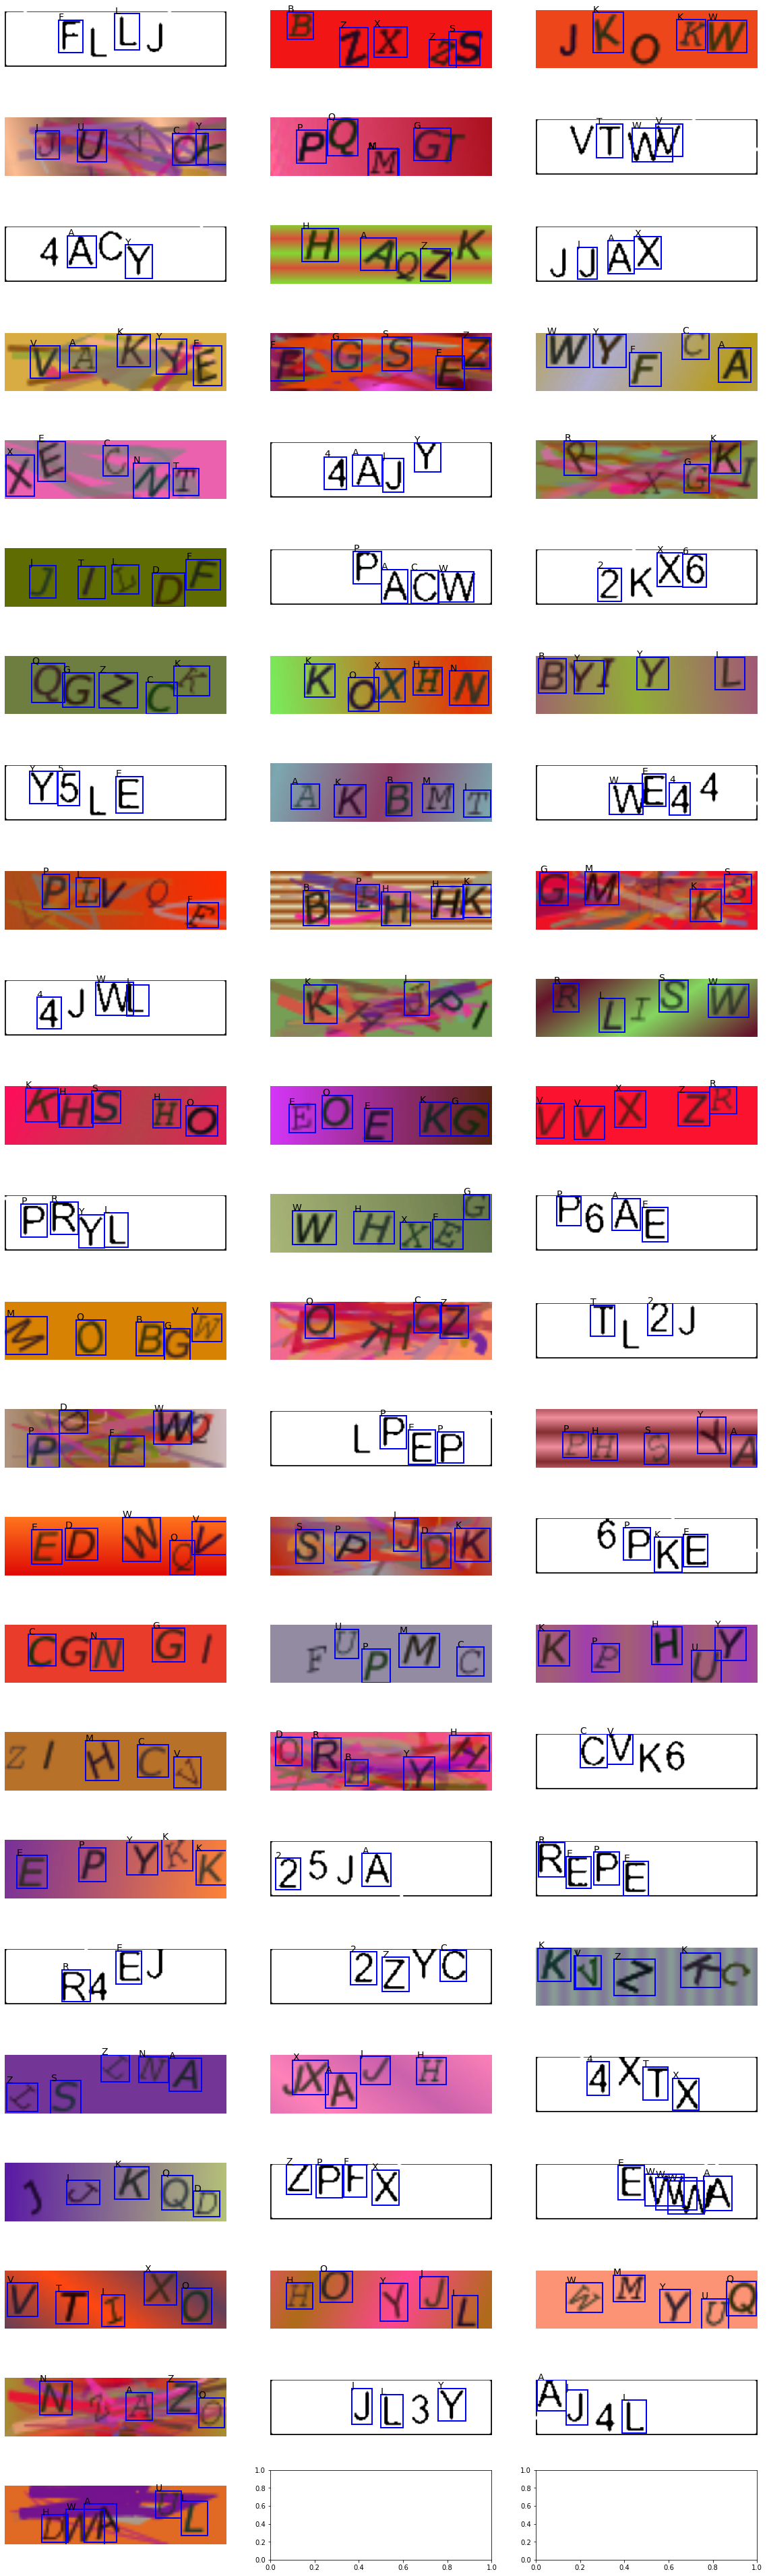

In [35]:
import matplotlib.patches as patches
from os.path import join

cntr = 0
threshold = 0.8

# Create figure and axes
fig,ax = plt.subplots(24, 3, figsize=(20, 70))

path = '/home/egor/job/CAPTCHA_recognition/data/labels+boxes/test'
for name in listdir(path):
    if 'jpg' not in name:
        continue
    full_name = join(path, name)
    im = Image.open(full_name).convert('RGB')
    img, pred_boxes, det_labels = detect(ssd_model, im, train_dataset.indx2lbl, 
                                         min_score=0.5, max_overlap=0.5, top_k=200)
    
    row, col = cntr // 3, cntr % 3
    # Display the image
    ax[row, col].imshow(im)

    # Create a Rectangle patch
    for (x0, y0, x1, y1), label in zip(pred_boxes, det_labels):
        w, h = x1 - x0, y1 - y0
        rect = patches.Rectangle((x0,y0),w,h,linewidth=2, edgecolor='b',facecolor='none')
        ax[row, col].text(x0, y0, f'{label}', fontsize=14)
        ax[row, col].add_patch(rect)
    
    ax[row, col].axis('off')
    cntr += 1
plt.show()